## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

import numpy as np
import torch

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

# with open('sonnets.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]
# assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# text = ''.join(text).lower()

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2020-05-10 19:02:32--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.1s    

2020-05-10 19:02:33 (2.25 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


### Data loading: "Eminem"

Датасет взять отсюда https://www.kaggle.com/thaddeussegura/eminem-lyrics-from-all-albums

In [128]:
with open('ALL_eminem.txt', 'r') as iofile:
    text_em = iofile.readlines()

In [129]:
text_em = ''.join(text_em).lower()

tokens = sorted(set(text_em))

# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

In [189]:
len(text_em)

925005

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [173]:
class RNN(nn.Module):
    def __init__(self, num_classes, emb_size, hidden_size):
        super().__init__()
        self.num_classes = num_classes
        self.embedding = nn.Embedding(num_classes, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.rnn_to_logits = nn.Linear(hidden_size, num_classes)

        
    def forward(self, x, initial_state=None):

        x_emb = self.embedding(x)
        h_seq, hid_state = self.rnn(x_emb, initial_state)
        next_logit = self.rnn_to_logits(h_seq)
        return next_logit, hid_state
    
    def initial_state(self, batch_size):
        """Return RNN state before it processes the first input (h0)."""
        return torch.zeros(batch_size, self.num_classes, requires_grad=True)

In [174]:
class EminemDataset(Dataset):
    def __init__(self, data, sample_length, token_to_idx, idx_to_token):
        self.data = data
        self.sample_length = sample_length
        self.token_to_idx = token_to_idx
        self.idx_to_token = idx_to_token
        
    def __len__(self):
        return len(self.data) - self.sample_length
    
    def __getitem__(self, index):
        text = self.data[index:index + self.sample_length]
        tokenized_seq = np.array([token_to_idx[token] for token in text])
        X = tokenized_seq[:-1]
        y = tokenized_seq[1:]
        return X, y

In [175]:
USE_CUDA = torch.cuda.is_available()

SAMPLE_LENGTH = 150
BATCH_SIZE = 1024
NUM_WORKERS = 24

NUM_CLASSES = len(tokens)
EMB_SIZE = 64
HIDDEN_SIZE = 128

LR = 1e-3
EPOCHS = 17

device = torch.device('cuda:0') if USE_CUDA else torch.device('cpu')

train_dataset = EminemDataset(text_em, SAMPLE_LENGTH, token_to_idx, idx_to_token)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True
)

rnn_model = RNN(NUM_CLASSES, EMB_SIZE, HIDDEN_SIZE).to(device)
optimizer = optim.Adam(rnn_model.parameters(), LR)
criterion = nn.CrossEntropyLoss()

def train(model, optimizer, criterion, epochs):
    t_epochs = tqdm(range(epochs))
    avg_train_losses = []

    for epoch in t_epochs:
        avg_train_loss = 0

        t_train_loader = tqdm(
            train_loader,
            total=len(train_loader),
            leave=False
        )

        for X_batch, y_batch in t_train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred, _ = model(X_batch)

            loss = criterion(y_pred.view(-1, model.num_classes), y_batch.view(-1))
            train_loss = loss.item()

            t_train_loader.set_postfix(train_loss=train_loss)
            avg_train_loss += train_loss / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        t_epochs.set_postfix(avg_train_loss=avg_train_loss)
        avg_train_losses.append(avg_train_loss)   
    return avg_train_losses

avg_train_losses = train(rnn_model, optimizer, criterion, EPOCHS)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

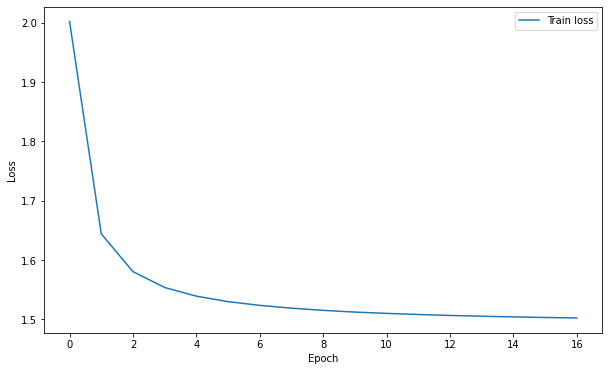

In [176]:
# Your plot code here
def plot_train_loss(avg_train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_losses, label='Train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend();

plot_train_loss(avg_train_losses)

In [177]:
def generate_sample(model, hid_state=None, seed_phrase=' god', length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)

    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        
        out, hid_state = model(x_sequence[:, :, i], hid_state)


    #start generating
    for _ in range(length - len(seed_phrase)):
        out, hid_state = model(x_sequence[:, :, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [188]:
print(
    generate_sample(
        rnn_model.cpu(),
        seed_phrase=' god',
        length=700,
        temperature=0.4
    )
)

 god damn that would get your fact it are you in the fucking done of a half are right there to said and speaking a storms
i made me to be stopping the world and let me stop when there to me and i was a straight the world is a beat to be down to the couple instant in the way to the been and started in the more so really don't make me the day is the trick and i was a things i got him in the shit is the black and got a back and straight off at the back in the light the way it and when you say that i'm a motherfuckers be starting to make a boood to the motherfuckin' one of the day what you wanna go the closet the back to the million to my bed back in the daughter the shove, i see the fuck me and


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [181]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, num_classes, emb_size, hidden_size):
        super().__init__()
        self.num_classes = num_classes
        self.one_hot_to_emb = nn.Linear(num_classes, emb_size)
        self.rnn = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.rnn_to_logits = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, initial_state=None):
        x_emb = self.one_hot_to_emb(F.one_hot(x, self.num_classes).float())
        h_seq, hid_state = self.rnn(x_emb, initial_state)
        next_logit = self.rnn_to_logits(h_seq)
        return next_logit, hid_state

In [182]:
lstm_model = LSTM(NUM_CLASSES, EMB_SIZE, HIDDEN_SIZE).to(device)
optimizer = optim.Adam(lstm_model.parameters(), LR)
criterion = nn.CrossEntropyLoss()

avg_train_losses = train(lstm_model, optimizer, criterion, EPOCHS)

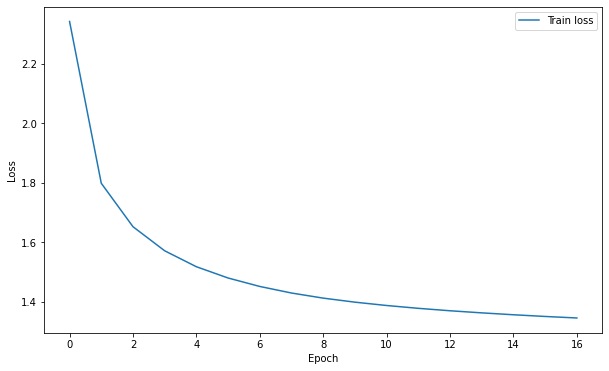

In [183]:
plot_train_loss(avg_train_losses)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [186]:
# Text generation with different temperature values here
temp = [0.1, 0.2, 0.5, 1.0, 2.0]

for temperature in temp:
    print(
        f'temperature = {temperature} \n\n',
        generate_text(
            lstm_model.cpu(),
            seed_phrase=' god',
            length=400,
            temperature=temperature
        ),
        '\n  -----------------------------------------------------------------------\n'
    )

temperature = 0.1 

  god damn down the same shit i can see the shit
i don't wanna be a starter so much off and stop it (i had a big with her)
i got a bottle of meant to be the streets
i got a strunk at the streets to the morning and started and the starting to see the shit
i was started to the streets to the morning and started and the best to see the show you to say i was so fall of my face
i don't wanna be the more 
  -----------------------------------------------------------------------

temperature = 0.2 

  god damn did that i said i was not a stranger
i wanna know what had to see you was a back to the mic and said that you can be a starter than to start the shit
i can see me for the streets to the mount of me
i don't know what i got a chainsaw in the morning
and i was supposed to be the steps of the trash to the back of my head
i could be a show your shit in the decres i got some song
i got a bottl 
  -----------------------------------------------------------------------

temp

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [187]:
# Saving and loading code here

MODEL_SAVE_PATH = 'lstm_model.pth'

torch.save(lstm_model.state_dict(), MODEL_SAVE_PATH)

lstm_model = LSTM(NUM_CLASSES, EMB_SIZE, HIDDEN_SIZE)
lstm_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

print(
    generate_text(
        lstm_model,
        seed_phrase=' god',
        length=1000,
        temperature=1.0
    )
)

 god i'm finhhole"
oppin' my body like you know
(i'm nothings)ure, tired or sock nobody
strentie tryin outta my song with shit i sit
bounches up back to the burter, it remind of off
but on the spittinem 'cause the vocace woman help you
abuer tire to control and how she's outside of the med

who the fuck is fighting and yebara!
as a circukes roiner witnece of wash out to flaf was
through the doctors, scar's raised them who well you explaintring
never give your peacest, ahmoor wrese little bite snow

[eminem:]
i’m never so way, bit along, stand torragh with spark with yeah

[butts)warded a gultand
elever down pain i don't know when these razo-rogger than seeking us
more, you better truly with how it
i was fucking come to accedly illermen
that's why we won?
hope it all be by a best me, amperty

i said i'm a neithess, what? (yeah)
everybody swand and i'ma teed on togething and, hurch i'll have it?
get at a feltranne
so many the comes the choated when i'm in your generate
i'll hate that may

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)